In [146]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split as splitter
import cProfile
import pstats
import os
import sys
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

print("Librerie importate con successo")

Librerie importate con successo


In [147]:
#Carico il dataset

data = pd.read_csv('../Datasets/kdd_prediction.csv', delimiter=',',
                       dtype={'protocol_type': str, 'service': str, 'flag': str, 'result': str})

data = data.sample(frac=1, random_state=1283).reset_index(drop=True) #shuffle
print("Shape del dataset : ", data.shape)

Shape del dataset :  (13451, 22)


Total :  13451
Normal :  7500
Malicious :  5951


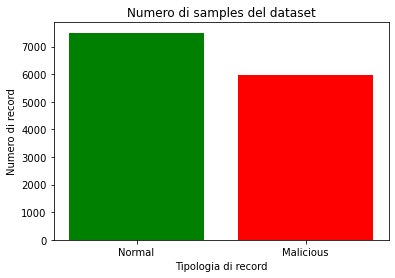

In [148]:
#Effettuo il plot del dataset

total_flows_count = data["result"].count()
normal_flows_count = len(data[data.result == "normal"])
anomaly_flows_count = len(data[data.result != "normal"])

print("Total : ",total_flows_count)
print("Normal : ",normal_flows_count)
print("Malicious : ",anomaly_flows_count)

# x-coordinates of left sides of bars  
left = [1, 1.5] 
  
# heights of bars 
height = [normal_flows_count, anomaly_flows_count] 
  
# labels for bars 
tick_label = ['Normal', 'Malicious'] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['green', 'red']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Numero di samples del dataset') 
  
plt.show() 

In [149]:
def preprocessing(data):
    for column in data.columns:
        if data[column].dtype == type(object):
            le = LabelEncoder()
            data[column] = le.fit_transform(data[column])

In [150]:
normal_data = data[data.result == "normal"] #prendo solo i valori "normali" 

#voglio che sia il train che la validation siano effettuati su record normali ma che siano tra loro differenti

data_train, data_val, data_test = np.split(normal_data, [int(.6*len(normal_data)), int(.8*len(normal_data))])

preprocessing(data_train)
preprocessing(data_val)
        
x_train = data_train.drop('result',axis=1) #rimuove la colonna result dal dataframe
x_val = data_val.drop('result', axis=1) #rimuove il label

print("Shape dataframe per il train : ", x_train.shape)
print("Shape dataframe per la validation : ", x_val.shape)

Shape dataframe per il train :  (4500, 21)
Shape dataframe per la validation :  (1500, 21)


In [151]:
arr_train = x_train.to_numpy() #conversione da dataframe ad array numpy
arr_train = arr_train.reshape(arr_train.shape[0],arr_train.shape[1],1) #converte la shape da 2d a 3d per layer LSTM
print("Training input shape: ", arr_train.shape)

arr_val = x_val.to_numpy()
arr_val = arr_val.reshape(arr_val.shape[0],arr_val.shape[1],1)
print("Validation input shape: ", arr_val.shape)


Training input shape:  (4500, 21, 1)
Validation input shape:  (1500, 21, 1)


In [152]:
model = keras.Sequential(
    [
       layers.Input(shape=(arr_train.shape[1], arr_train.shape[2])),
       layers.LSTM(16, activation='relu', return_sequences=True), 
       layers.LSTM(8, activation='relu', return_sequences=False),
        
       layers.RepeatVector(arr_train.shape[1]), 
        
        
       layers.LSTM(8, activation='relu', return_sequences=True),
       layers.LSTM(16, activation='relu', return_sequences=True),
       layers.TimeDistributed(layers.Dense(1))    
    ]
)
model.compile( optimizer='adam', loss='mse')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 21, 16)            1152      
_________________________________________________________________
lstm_27 (LSTM)               (None, 8)                 800       
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 21, 8)             0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 21, 8)             544       
_________________________________________________________________
lstm_29 (LSTM)               (None, 21, 16)            1600      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 21, 1)             17        
Total params: 4,113
Trainable params: 4,113
Non-trainable params: 0
____________________________________________________

In [153]:
history = model.fit(
    arr_train,
    arr_train,
    epochs=50,
    batch_size=150,
    validation_data=(arr_val, arr_val),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, mode="min")
    ],
)

Epoch 1/50
30/30 [==============================] - 2s 71ms/step - loss: 5.0345 - val_loss: 3.6043
Epoch 2/50
30/30 [==============================] - 1s 39ms/step - loss: 4.8807 - val_loss: 3.5679
Epoch 3/50
30/30 [==============================] - 1s 42ms/step - loss: 4.7569 - val_loss: 3.4808
Epoch 4/50
30/30 [==============================] - 1s 42ms/step - loss: 4.4535 - val_loss: 3.2888
Epoch 5/50
30/30 [==============================] - 1s 42ms/step - loss: 3.0453 - val_loss: 2.3326
Epoch 6/50
30/30 [==============================] - 1s 42ms/step - loss: 1.0038 - val_loss: 2.5093
Epoch 7/50
30/30 [==============================] - 1s 40ms/step - loss: 0.7898 - val_loss: 2.5203
Epoch 8/50
30/30 [==============================] - 1s 40ms/step - loss: 0.8064 - val_loss: 2.4790
Epoch 9/50
30/30 [==============================] - 1s 42ms/step - loss: 0.7801 - val_loss: 2.4572
Epoch 10/50
30/30 [==============================] - 1s 42ms/step - loss: 0.7589 - val_loss: 2.4417
Epoch 11/

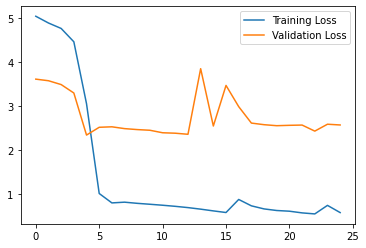

In [154]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

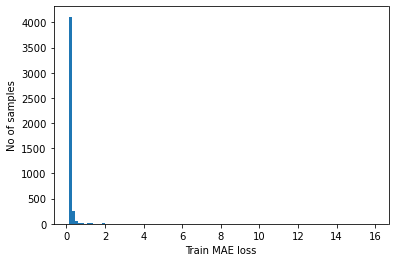

Reconstruction error threshold:  2.0082835081152277


In [155]:
x_train_pred = model.predict(arr_train)
train_mae_loss = np.mean(np.abs(x_train_pred - arr_train), axis=1)
train_mae_loss = train_mae_loss.ravel() #converte l'array numpy in 1d
train_mae_loss = np.sort(train_mae_loss) #quicksort


train_mae_loss_len = len(train_mae_loss)
n_index = int(0.999*train_mae_loss_len)
plt.hist(train_mae_loss, bins=100)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
train_mae_loss_split = train_mae_loss[:n_index]
threshold = np.max(train_mae_loss_split)
print("Reconstruction error threshold: ", threshold)

In [156]:
#data_test
#il dataset per il test sarà formato dai 1500 sample normali prelevati precedentemente a cui aggiungerò dei sample anomali
#in particolare prelevo il 20% dei sample anomali e li concateno ai 1500 normali precedentemente ottenuti

anomaly_data = data[data.result != "normal"] #prendo solo i valori "anomali"

percentage = 20
anomaly_test_data = anomaly_data.head(int(len(anomaly_data)*(percentage/100)))

frames = [data_test, anomaly_test_data]
final_test_data = pd.concat(frames)

print("Shape del dataset per il test: ", final_test_data.shape)

Shape del dataset per il test:  (2690, 22)


Total :  2690
Normal :  1500
Malicious :  1190


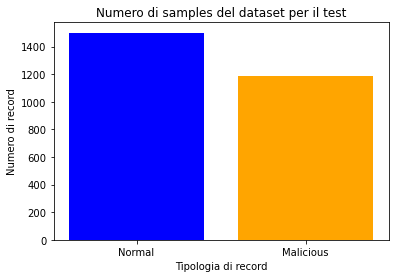

x_test shape : (2690, 21)


In [157]:
total_flows_count_test = final_test_data["result"].count()
normal_flows_count_test = len(final_test_data[final_test_data.result == "normal"])
anomaly_flows_count_test = len(final_test_data[final_test_data.result != "normal"])

print("Total : ",total_flows_count_test)
print("Normal : ",normal_flows_count_test)
print("Malicious : ",anomaly_flows_count_test)

# x-coordinates of left sides of bars  
left = [1, 1.5] 
  
# heights of bars 
height = [normal_flows_count_test, anomaly_flows_count_test] 
  
# labels for bars 
tick_label = ['Normal', 'Malicious'] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['blue', 'orange']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Numero di samples del dataset per il test') 
  
plt.show() 

preprocessing(final_test_data)
x_test = final_test_data.drop('result',axis=1) #rimuove la colonna result dal dataframe
print("x_test shape :", x_test.shape)

In [158]:
arr_test = x_test.to_numpy() #conversione da dataframe ad array numpy
arr_test = arr_test.reshape(arr_test.shape[0],arr_test.shape[1],1) #converte la shape da 2d a 3d per layer LSTM
print("Training input shape: ", arr_test.shape)

Training input shape:  (2690, 21, 1)


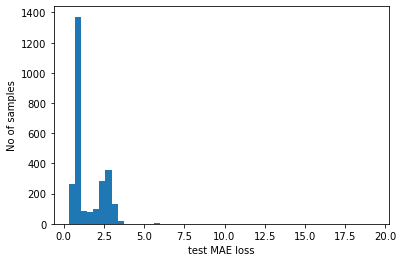

Number di sample anomali rilevati:  832
Numero di sample anomali rivelati erroneamente:  500
Numero di sample anomali rilevati correttamente:  332
Numero di sample anomali non rivelati:  855


Indices of anomaly samples:  (array([   6,   11,   14,   30,   32,   42,   45,   56,   58,   64,   68,
         69,   70,   71,   81,   87,   93,   96,  104,  109,  117,  124,
        134,  141,  143,  145,  148,  155,  157,  165,  169,  172,  173,
        186,  187,  188,  189,  190,  193,  199,  201,  205,  207,  208,
        213,  221,  223,  227,  228,  230,  238,  242,  243,  259,  261,
        283,  285,  287,  289,  293,  296,  313,  316,  320,  329,  348,
        349,  357,  362,  375,  379,  380,  390,  394,  399,  405,  407,
        408,  413,  429,  431,  462,  473,  495,  497,  509,  515,  528,
        530,  532,  553,  560,  572,  582,  583,  584,  593,  594,  607,
        608,  616,  618,  620,  628,  633,  635,  644,  654,  670,  682,
        689,  691,  693,  698,  699,  700,  711

In [159]:
arr_test_pred = model.predict(arr_test)
test_mae_loss = np.mean(np.abs(arr_test_pred - arr_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))
                                       
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

#print(data_test_with_label)

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
count = 0
false_negative = 0
false_positive = 0


for i in anomalies:
    if ( i == True ):
        if ( data_test_with_label.iloc[count].result == "normal"):
            false_negative = false_negative + 1
    if (i == False):
        if( data_test_with_label.iloc[count].result != "normal"):
            false_positive = false_positive + 1
    count = count + 1
        
print("Number di sample anomali rilevati: ", np.sum(anomalies))
print("Numero di sample anomali rivelati erroneamente: ", false_negative)
print("Numero di sample anomali rilevati correttamente: ", np.sum(anomalies)-false_negative)
print("Numero di sample anomali non rivelati: ", false_positive)
print("")
print("")
print("Indices of anomaly samples: ", np.where(anomalies))                                       